# Insights from the One-Zone Freefall model
In this section, we compare the 1-zone freefall model and have a sense of which cooling/heating process are at work at various density.
In particular we are looking into the same reaction network in Grackle that has `MultiSpecies = 2` setup, the 9 species chemical network. 
This particular network includes 21 reactions, and various heating and cooling process. 
It aims at describing the chemistry and thermodynamics of metal-free gas. 

One-zone freefall model has been adopted to study the thermal and chemical evolution of gravitationally collapsing protostellar clouds. For more details of the model, readers can consult the [Omukai2000](https://iopscience.iop.org/article/10.1086/308776/fulltext/40822.text.html) for the details of the model setup and the chemistry involved. This is also one of the test case from $\texttt{Dengo}$, where comparison is made against the same 1-zone freefall model from $\texttt{Grackle}$. The implementation can be found under the [$\texttt{Dengo}$ Github repo](https://github.com/hisunnytang/dengo-merge/blob/master/examples/test/evolve_free_fall.py).

In [1]:
%load_ext autoreload
%autoreload 2

import sympy
from sympy import lambdify
from dengo.chemical_network import (
    ChemicalNetwork,
    reaction_registry,
    cooling_registry,
    species_registry,
)

import dengo.primordial_rates
import dengo.primordial_cooling

import numpy as np
import matplotlib.pyplot as plt
import pickle


def load_obj(name):
    with open(name + ".pkl", "rb") as f:
        return pickle.load(f)


dengo.primordial_rates.setup_primordial()

from utils import temperature_data, evaluate_cooling_terms

 ChiantiPy version 0.12.0 
 found PyQt5 widgets
 using PyQt5 widgets


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/tools/data.py:71: UserWarning: klgfb files are not present: 
  it will not be possible to use the freeBound continuum method
  warnings.warn('klgfb files are not present: \n  it will not be possible to use the freeBound continuum method')
/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")
/home/kwoksun2/anaconda3/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/kwoksun2/.config/yt/ytrc is deprecated in favor of /home/kwoksun2/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0


## Various Heating/Cooling Process At Work
In the below, we visualize how various thermal process dominates in different density ranges.
`compressional` heating is the approximate energy input from the gravitational work acting on the gas parcel. 
`Gloverabel08` refers to the H2 continuum cooling, it is the dominant cooling process at density below $\rho \sim 10^{-12}\mathrm{g ~ cm^{3}}$. In low density regimes, compressional heating wins over the continnum cooling, resulting ina slow climb in temperature as density increases. 
`h2formation` refers to the net binding energy release/ absorbed from the formation/dissociation of molecular hydrogen. At density of $\gt 10^{-16} \mathrm{g ~ cm^{3}} $, the three-body reaction is ruling formation pathways for molecular hydrogen, binding energy contributes a significant part to the overall thermal process. As the molecular hydrogen are built up slowly, the dissociation of $H_2$ molecules begins to come into play and begin to cool down the gas as the $H_2$ breaks into Hydrogen atoms.
Collision-Induced emission is also expected to be significant at higher density of around  $10^{-8} \mathrm{g ~ cm^{3}}  $  onwards.

In [4]:
from utils import calculate_instant_cooling_rates

init_values = load_obj("/home/kwoksun2/data/dengo-merge/cvode_klu/freefall_dengo")
init_values["mdensity"] = init_values["density"][1:] * 1.67e-24
init_values["z"] = np.ones_like(init_values["ge"]) * 20


density = init_values["density"][1:]
all_rates = calculate_instant_cooling_rates(init_values, density, tidx=None)
all_rates["compressional"] = (
    (5 / 3 - 1)
    * init_values["ge"]
    * (32 * 4 / 3 * 6.67384e-8 * init_values["mdensity"]) ** 0.5
    * init_values["mdensity"]
)

Text(0, 0.5, '$\\frac{d\\epsilon}{dt} \\times t_{ff}$')

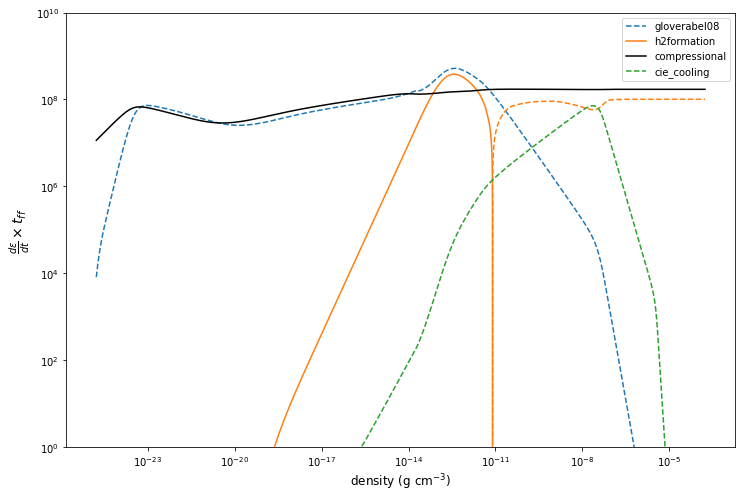

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(
    init_values["mdensity"],
    -all_rates["gloverabel08"] / init_values["mdensity"] ** 1.5,
    label="gloverabel08",
    ls="--",
    color="C0",
)
plt.loglog(
    init_values["mdensity"],
    all_rates["h2formation"] / init_values["mdensity"] ** 1.5,
    label="h2formation",
    color="C1",
)
plt.loglog(
    init_values["mdensity"],
    -all_rates["h2formation"] / init_values["mdensity"] ** 1.5,
    ls="--",
    color="C1",
)

plt.loglog(
    init_values["mdensity"],
    all_rates["compressional"] / init_values["mdensity"] ** 1.5,
    label="compressional",
    color="k",
)
plt.loglog(
    init_values["mdensity"],
    -all_rates["cie_cooling"] / init_values["mdensity"] ** 1.5,
    label="cie_cooling",
    ls="--",
    color="C2",
)
plt.ylim(1e0, 1e10)
plt.legend()
plt.xlabel("density ($\mathrm{g ~ cm^{-3}})$", fontsize=12)
plt.ylabel(r"$\frac{d\epsilon}{dt} \times t_{ff}$", fontsize=14)

## The $\rho -T $ and $f_{H_2}$ plot
The plot below demonstrates temperature evolution and the molecular hydrogen fraction as a function of density.

Text(0, 0.5, '$f_{\\mathrm{H_2}}$')

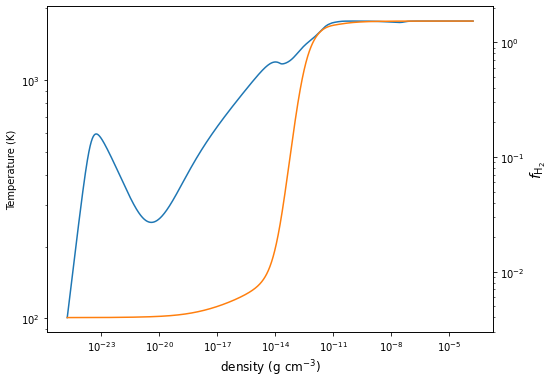

In [11]:
plt.figure(figsize=(8, 6))
plt.loglog(
    init_values["mdensity"], init_values["T"], color="C0", label="Temperature(K)"
)
plt.ylabel("Temperature (K)")
plt.xlabel("density ($\mathrm{g ~ cm^{-3}})$", fontsize=12)

ax = plt.twinx()
ax.loglog(
    init_values["mdensity"],
    init_values["H2_1"] / init_values["mdensity"] * 1.67e-24 * 2.01588,
    color="C1",
    label="H2I Fraction",
)
ax.set_ylabel(r"$f_{\mathrm{H_2}}$", fontsize=14)

## Identify the Phase Space of Heating and Cooling at High Density
While in the above, we demonstrate that how various chemical process plays a role for a free-falling parcel. This is however is not fully representative of the full phase space of which one would encounter in a full-blown hydrodynamical chemical kinetics simulations. In the below, we are particularly interested in learning the phase space at which the chemical network can achieve a thermal equilibrium. 

We initialize a 3d grid of initial conditions with logarithmically spaced density,temperature, and $H_2$ fraction. And we evaluate the cooling rates over this fiducial 3d grid.

In [48]:
from dengo.chemistry_constants import kboltz, mh


ncells = 256
_rho = np.logspace(-16, -8, ncells)
_T = np.logspace(2.3, 3.7, ncells)
_fH2 = np.logspace(-1, -0.0001, ncells)

rho, T, fH2 = np.meshgrid(_rho, _T, _fH2)

rho = rho.flatten()
T = T.flatten()
fH2 = fH2.flatten()

H2_1 = 0.76 * rho * fH2
H_1 = 0.76 * rho - H2_1
He_1 = 0.24 * rho


init_values = {}
init_values["H2_1"] = H2_1 / mh
init_values["H_1"] = H_1 / mh
init_values["He_1"] = He_1 / mh

tiny = 1e-6
init_values["He_2"] = rho * tiny / mh
init_values["He_3"] = rho * tiny / mh
init_values["H_2"] = rho * tiny / mh
init_values["H2_2"] = rho * tiny / mh
init_values["H_m0"] = rho * tiny / mh
init_values["de"] = rho * tiny / mh


init_values["ge"] = (
    (
        init_values["H2_1"] / 2 / (7 / 5 - 1)
        + init_values["H_1"] / (5 / 3 - 1)
        + init_values["He_1"] / 4 / (5 / 3 - 1)
    )
    * kboltz
    * T
    / rho
)
init_values["T"] = T


init_values["mdensity"] = rho
init_values["z"] = np.ones_like(init_values["ge"]) * 20


all_rates = calculate_instant_cooling_rates(
    init_values,
    rho / mh,
)
rates3d = all_rates["chemical"].reshape(ncells, ncells, ncells)

## Net-Heating Rate in the Grid Space
Blue/Red regions are where chemical cooling/heating is dominant. Different panels corresponds to different $H_2$ fraction. When the molecular hydrogen fraction is low, heating is significant at low temperature, and a sharp transition is observed as the temperature increased. That can be explained by the increased dissociation rates at those phase space, where significant cooling is expected from the conversion of thermal energy into the binding energy. As the H2 fraction increases, h2 formation heating becomes less and less significant. Finally, when the cloud reaches close to fully molecular, the cloud would undergo chemical cooling in almost all of the phase space explored. 

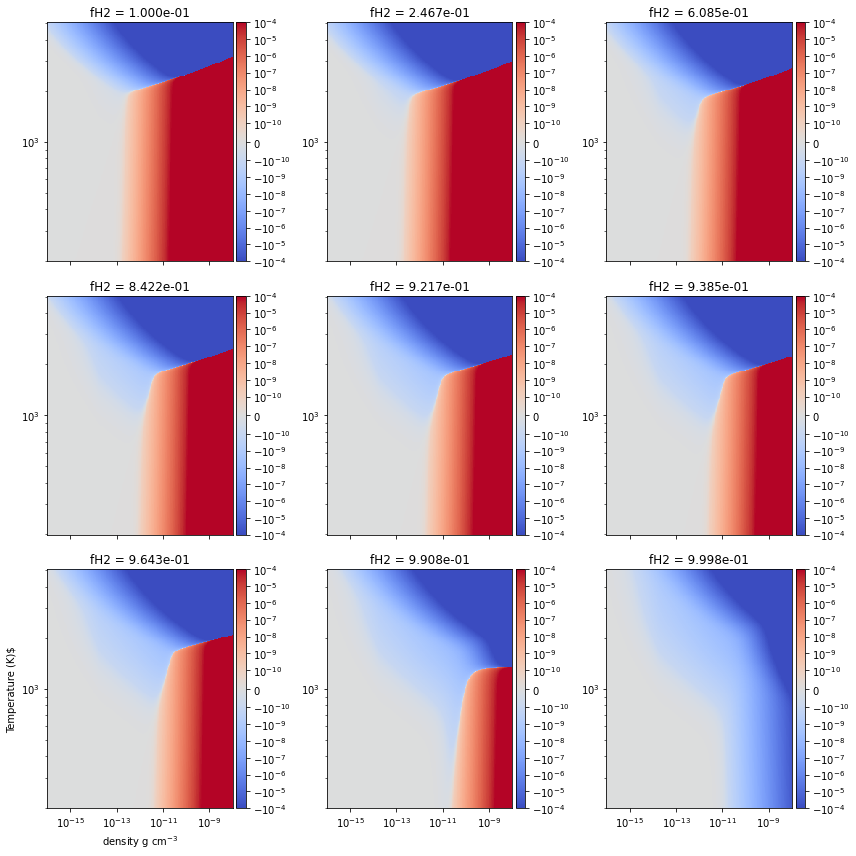

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import SymLogNorm, LogNorm

indices = [0, 100, 200, -20, -10, -8, -5, -2, -1]
f, axes = plt.subplots(3, 3, sharex=True, figsize=(12, 12))

ge3d = init_values["ge"]
count = 0
for ax, idx in zip(axes.flat, indices):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.set_title(f"fH2 = {_fH2[idx]:.3e}")
    im = ax.pcolormesh(
        rho.reshape(ncells, ncells, ncells)[:, :, idx],
        T.reshape(ncells, ncells, ncells)[:, :, idx],
        rates3d[:, :, idx],
        norm=SymLogNorm(linthresh=1e-10, vmin=-1e-4, vmax=1e-4),
        cmap="coolwarm",
    )
    f.colorbar(im, cax=cax)
    ax.set_yscale("log")

    if count == 6:
        ax.set_xlabel("density $\mathrm{g ~ cm^{-3}}$")
        ax.set_ylabel("Temperature (K)$")
    count += 1


ax.set_xscale("log")

plt.tight_layout()

## The $T-\rho-f_{H_2}$  thermal equilibrium surface

The region in phase space where chemical heating balances out the chemical cooling is where thermal equilibrium is achieved. If the gas parcel is too hot, chemical cooling would begin to cool the gas parcel, and vice versa. It is therefore a self-regulating mechanism where the thermal equilibrium can be achieved. In the below, we identified the region where this transition happens, and plot the equilibrium temperature required for such equilibrium to take place at different density and moelcular hydrogen fraction.

0
100
200


Text(0, 0.5, 'temperature ($\\mathrm{K}$)')

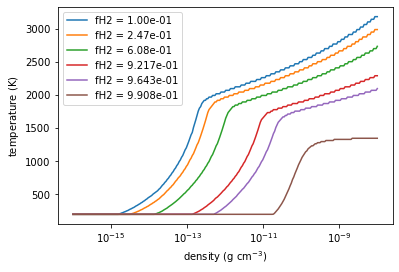

In [86]:
signs3d = np.sign(rates3d)
tequil = []
for _ifh2 in range(ncells):
    tnow = []
    for i in range(ncells):
        tmp = _T[(np.diff(signs3d[:, i, _ifh2], prepend=1) != 0)]
        if len(tmp) == 1:
            tnow.append(tmp.item())
        else:
            tnow.append(np.nan)

    tequil.append(tnow)

for i in range(0, ncells, 100):
    print(i)
    plt.semilogx(_rho, tequil[i], label=f"fH2 = {_fH2[i]:.2e}")

i = -10
plt.semilogx(_rho, tequil[i], label=f"fH2 = {_fH2[i]:.3e}")

i = -5
plt.semilogx(_rho, tequil[i], label=f"fH2 = {_fH2[i]:.3e}")

i = -2
plt.semilogx(_rho, tequil[i], label=f"fH2 = {_fH2[i]:.3e}")


plt.legend()

plt.xlabel("density ($\mathrm{g} ~ \mathrm{cm}^{-3}$)")
plt.ylabel("temperature ($\mathrm{K}$)")

Text(0.5, 0, '$\\log \\rho$ ')

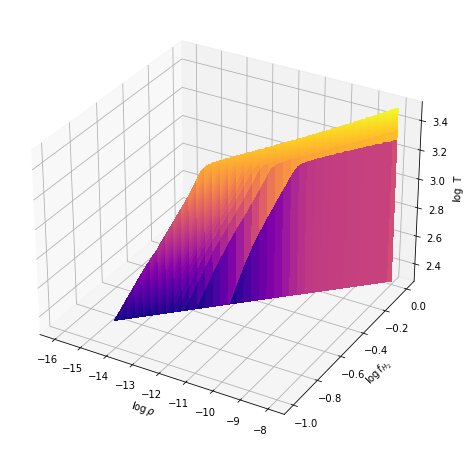

In [87]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

im = ax.plot_surface(
    np.log10([_rho] * ncells),
    np.log10([_fH2] * ncells),
    np.log10(tequil),
    cmap="plasma",
    linewidth=0,
    antialiased=False,
)

ax.set_zlabel(r"$\log$ T")
ax.set_ylabel(r"$\log f_{H_2}$")
ax.set_xlabel(r"$\log \rho$ ")

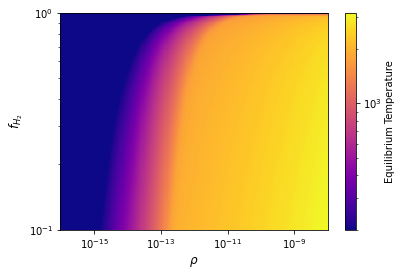

In [96]:
plt.pcolor(_rho, _fH2, tequil, cmap="plasma", norm=LogNorm())
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\rho$", fontsize=12)
plt.ylabel("$f_{H_2}$", fontsize=12)
cbar = plt.colorbar()
cbar.set_label("Equilibrium Temperature")

/tmp/ipykernel_16537/3796042406.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(


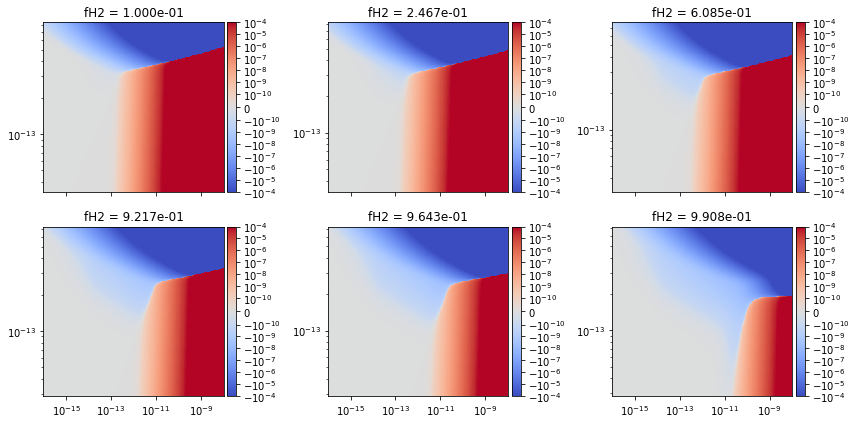

In [89]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import SymLogNorm, LogNorm

indices = [0, 100, 200, -10, -5, -2]
f, axes = plt.subplots(2, 3, sharex=True, figsize=(12, 6))

ge3d = init_values["ge"]

for ax, idx in zip(axes.flat, indices):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.set_title(f"fH2 = {_fH2[idx]:.3e}")
    im = ax.pcolormesh(
        rho.reshape(ncells, ncells, ncells)[:, :, idx],
        (ge3d).reshape(ncells, ncells, ncells)[:, :, idx],
        rates3d[:, :, idx],
        norm=SymLogNorm(linthresh=1e-10, vmin=-1e-4, vmax=1e-4),
        cmap="coolwarm",
    )
    f.colorbar(im, cax=cax)
    ax.set_yscale("log")

#     ax.loglog(_rho, tequil[idx], color='w')
# plt.colorbar(im, cax = ax)
ax.set_xscale("log")

plt.tight_layout()

## The phase space of net latent energy
There is significant latent energy tapped from atomic hydrogen. They are released as molecular hydrogen is formed. In the below we adjust the y-axis to be the specific thermal energy plus the latent energy from the cloud.

In [90]:
ge = (
    (
        init_values["H2_1"] / 2 / (7 / 5 - 1)
        + init_values["H_1"] / (5 / 3 - 1)
        + init_values["He_1"] / 4 / (5 / 3 - 1)
    )
    * kboltz
    * T
    / rho
)
h_latent = init_values["H_1"] * 7.176e-12 / 2 / rho

/tmp/ipykernel_16537/2780049909.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(


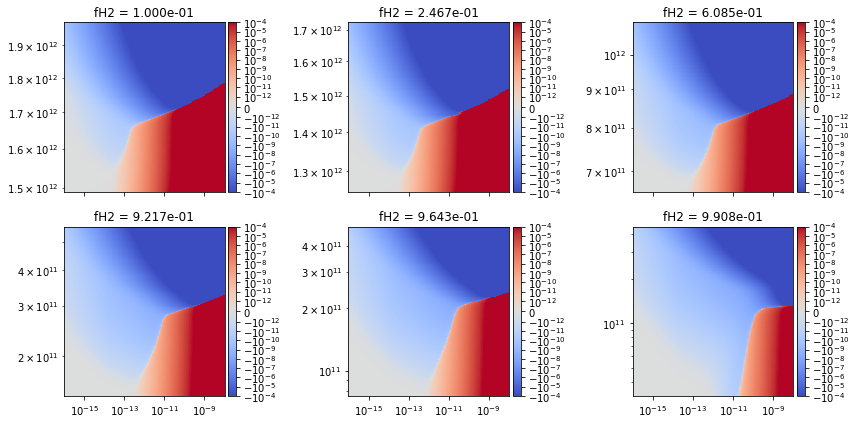

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

indices = [0, 100, 200, -10, -5, -2]
f, axes = plt.subplots(2, 3, sharex=True, figsize=(12, 6))

ge3d = init_values["ge"]

for ax, idx in zip(axes.flat, indices):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.set_title(f"fH2 = {_fH2[idx]:.3e}")
    im = ax.pcolormesh(
        rho.reshape(ncells, ncells, ncells)[:, :, idx],
        (h_latent + ge).reshape(ncells, ncells, ncells)[:, :, idx],
        rates3d[:, :, idx],
        norm=SymLogNorm(linthresh=1e-12, vmin=-1e-4, vmax=1e-4),
        cmap="coolwarm",
    )
    f.colorbar(im, cax=cax)
    ax.set_yscale("log")

#     ax.loglog(_rho, tequil[idx], color='w')
# plt.colorbar(im, cax = ax)
ax.set_xscale("log")

plt.tight_layout()

In [92]:
signs3d = np.sign(rates3d)

tidx = []
for _ifh2 in range(ncells):
    tnow = []
    for i in range(ncells):
        tmp = np.where(np.diff(signs3d[:, i, _ifh2], prepend=1) != 0)[0]
        if len(tmp) == 1:
            tnow.append(tmp.item())
        else:
            tnow.append(0)

    tidx.append(tnow)

Text(0.5, 0, '$\\log \\rho$ ')

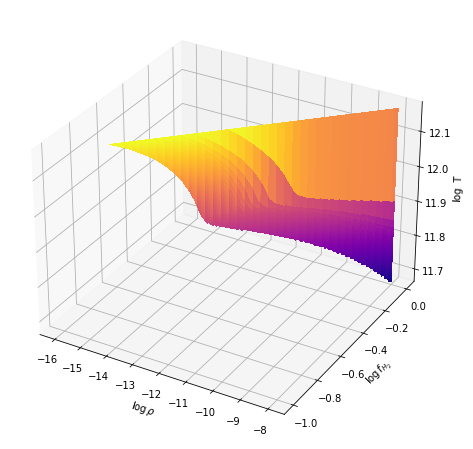

In [93]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

ax.plot_surface(
    np.log10([_rho] * ncells),
    np.log10([_fH2] * ncells),
    np.log10((h_latent + ge)[tidx]),
    cmap="plasma",
    linewidth=0,
    antialiased=False,
)

ax.set_zlabel(r"$\log$ T")
ax.set_ylabel(r"$\log f_{H_2}$")
ax.set_xlabel(r"$\log \rho$ ")

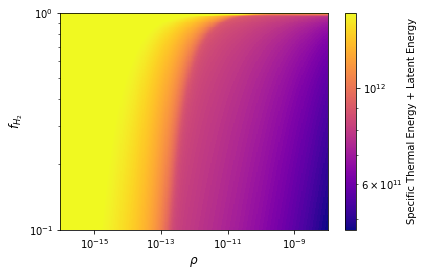

In [94]:
plt.pcolor(
    _rho,
    _fH2,
    (h_latent + ge)[tidx],
    cmap="plasma",
    norm=LogNorm()
    #     linewidth=0,
    #     antialiased=False
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\rho$", fontsize=12)
plt.ylabel("$f_{H_2}$", fontsize=12)
cbar = plt.colorbar()
cbar.set_label("Specific Thermal Energy + Latent Energy")